In [1]:
import os, re
import pandas as pd
import numpy as np
from pyfaidx import Fasta 

import importlib
import _config
importlib.reload(_config)
from _config import DATA_DIR, OUT_PLACE 

#use your data directory to locate your data files
NOREPEATS_DATA_DIR = os.path.join(DATA_DIR, "no_repeats")
HYPER_DATA_DIR = os.path.join(DATA_DIR, "encode")
JEN_DATA_DIR = os.path.join(DATA_DIR, "jen")
SHIBATA_DATA_DIR = os.path.join(DATA_DIR, "shibata")

OUT_DIR = os.path.join(OUT_PLACE,"eccdna")
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)
    
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
import argparse
import seaborn as sns
%matplotlib inline

Note: if percentages or raw numbers of ES, MN, heart, or liver eccdna/hypersensitivity around genes are needed, just import gene_file or gene_file_percent (do not recalculate everything)

# Q: Does differential chromatin accessibility predict differential eccdna expression in two different cell types?

## Q: How do we compute differential eccdna expression with two eccdna datasets that vary in size and number of unique eccdnas?

Organize hypersensitivity and eccdna density as a 20,000 bp region around each gene. Each gene has a specific MN and ES hypersensitivity as well as eccdna percentage associated with it. Processed dataframe is saved as gene_bounds_percent.csv

In [129]:
refseq = pd.read_csv("/cluster/bh0085/genomes/mm10_refseq.csv", delimiter = "\t")
gene_bounds =pd.concat([refseq.groupby("name2").cdsStart.min().rename("start"),
                    refseq.groupby("name2").cdsEnd.max().rename("end"),
                   refseq.groupby("name2").chrom.first().rename("chrom"),
                   refseq.groupby("name2").strand.first().rename("strand")], axis = 1)
gene_bounds = gene_bounds.loc[gene_bounds.end-gene_bounds.start < 1000000] #filters out genes that are larger than 1 mil

In [130]:
ES_eccdna_path = os.path.join(NOREPEATS_DATA_DIR, "ES-1_norepeats.bed")
ES_eccdna_loci = pd.read_csv(ES_eccdna_path, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  

In [ ]:
MN_eccdna_path = os.path.join(NOREPEATS_DATA_DIR, "MN-1_norepeats2.bed")
MN_eccdna_loci = pd.read_csv(MN_eccdna_path, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  

In [131]:
heart_eccdna_path = os.path.join(SHIBATA_DATA_DIR, "converted_mm10_heart.bed")
heart_eccdna_loci = pd.read_csv(heart_eccdna_path, 
                                names = ['chrom','start','end','readcount','random'], delimiter = '\t')

In [132]:
brain_eccdna_path = os.path.join(SHIBATA_DATA_DIR, "converted_mm10_brain.bed")
brain_eccdna_loci = pd.read_csv(brain_eccdna_path, 
                                names = ['chrom','start','end','readcount','random'], delimiter = '\t')

In [222]:
liver_eccdna_path = os.path.join(SHIBATA_DATA_DIR, "converted_mm10_liver.bed")
liver_eccdna_loci = pd.read_csv(liver_eccdna_path, 
                                names = ['chrom','start','end','readcount','random'], delimiter = '\t')

In [223]:
ES_path = os.path.join(HYPER_DATA_DIR, "ES_ENCFF319IPQ.bed")
ES_loci = pd.read_csv(ES_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

MN_new_path = os.path.join(HYPER_DATA_DIR, "ENCFF979URU.bed")
MN_new_loci = pd.read_csv(MN_new_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

heart_path = os.path.join(HYPER_DATA_DIR, "heart_ENCFF810UXC.bed")
heart_loci = pd.read_csv(heart_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

brain_path = os.path.join(HYPER_DATA_DIR, "forebrain_ENCFF011OFJ.bed")
brain_loci = pd.read_csv(brain_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

liver_path = os.path.join(HYPER_DATA_DIR, "liver_ENCFF837DLJ.bed")
liver_loci = pd.read_csv(liver_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

In [134]:
gene_bounds["MN_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["MN_ecc_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)

In [135]:
gene_bounds["ES_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["ES_ecc_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)

In [136]:
gene_bounds["heart_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["heart_ecc_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)

In [137]:
gene_bounds["brain_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["brain_ecc_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)

In [224]:
gene_bounds["liver_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["liver_ecc_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)

In [138]:
gene_bounds["start_region"] = gene_bounds.start-10000
gene_bounds["end_region"] = gene_bounds.end+10000

In [139]:
def eccdna_coverage(loci, celltype, cellfile):
    """
    Modifies [loci] eccdna coverage column for the particular celltype to reflect base coverage within a 
    20000 window of each gene 
    
    Precondition:
    loci is a gene dataframe
    celltype is a string describing the cell type
    cellfile is eccdna dataframe
    """
    cellfile_idxed = cellfile.set_index("start", drop=False).sort_index()
    
    for gene in loci.itertuples():
        for h in cellfile_idxed.loc[gene.start_region-10000:gene.end_region+10000].itertuples():
            if h.chrom == gene.chrom:
                start = max(gene.start_region, h.start)
                end = min(gene.end_region, h.end)
                length = max(0, end-start)
                if length==0: continue
                loci.at[gene.Index, celltype + "_ecc_cov"] = loci.at[gene.Index, celltype + "_ecc_cov"]+length   


In [140]:
def hyper_coverage_new(loci, celltype, cellfile):
    """
    Modifies [loci] hypersensitivity coverage column for the particular celltype to reflect base coverage within a 
    20000 window of each gene
    
    Precondition:
    loci is gene dataframe
    celltype is a string describing the cell type
    cellfile is hypersensitivity dataframe for a particular [celltype]
    """
    cellfile_idxed = cellfile.set_index("start", drop=False).sort_index()
    
    for gene in loci.itertuples():
        for h in cellfile_idxed.loc[gene.start_region-10000:gene.end_region+10000].itertuples():
            if h.chrom == gene.chrom:
                start = max(gene.start_region, h.start)
                end = min(gene.end_region, h.end)
                length = max(0, end-start)
                if length==0: continue
                loci.at[gene.Index, celltype + "_hyper_cov"] = loci.at[gene.Index, celltype + "_hyper_cov"]+length   


In [141]:
eccdna_coverage(gene_bounds, "ES", ES_eccdna_loci)
eccdna_coverage(gene_bounds, "MN", MN_eccdna_loci)
hyper_coverage_new(gene_bounds, "ES", ES_loci)
hyper_coverage_new(gene_bounds, "MN", MN_new_loci)

In [142]:
eccdna_coverage(gene_bounds, "heart", heart_eccdna_loci)
hyper_coverage_new(gene_bounds, "heart", heart_loci)

In [143]:
eccdna_coverage(gene_bounds, "brain", brain_eccdna_loci)
hyper_coverage_new(gene_bounds, "brain", brain_loci)

In [226]:
eccdna_coverage(gene_bounds, "liver", liver_eccdna_loci)
hyper_coverage_new(gene_bounds, "liver", liver_loci)

In [145]:
gene_bounds.to_csv("gene_file.csv", sep='\t')

In [230]:
def convert_to_percent(gene_bounds):
    """
    Converts all hypersensitivity, eccdna coverage columns into percent coverage instead of raw numbers
    """
    gene_bounds.ES_hyper_cov = gene_bounds.ES_hyper_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.MN_hyper_cov = gene_bounds.MN_hyper_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.heart_hyper_cov = gene_bounds.heart_hyper_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.brain_hyper_cov = gene_bounds.brain_hyper_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.liver_hyper_cov = gene_bounds.liver_hyper_cov/(gene_bounds.end_region-gene_bounds.start_region)*100

    gene_bounds.ES_ecc_cov = gene_bounds.ES_ecc_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.MN_ecc_cov = gene_bounds.MN_ecc_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.heart_ecc_cov = gene_bounds.heart_ecc_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.brain_ecc_cov = gene_bounds.brain_ecc_cov/(gene_bounds.end_region-gene_bounds.start_region)*100
    gene_bounds.liver_ecc_cov = gene_bounds.liver_ecc_cov/(gene_bounds.end_region-gene_bounds.start_region)*100

In [229]:
convert_to_percent(gene_bounds)

In [232]:
gene_bounds.to_csv("gene_file_percent.csv", sep='\t')

## Q: How to determine threshold for the two different cell types?

In [203]:
def gene_counts(genes, celltype, threshold):
    """
    Returns: number of all genes above that threshold in terms of percent hypersensitivity coverage 
    around that gene
    """
    return len(genes.loc[genes[celltype+"_hyper_cov"] > threshold])

In [89]:
def threshold_plot(loci, celltype):
    """
    Creates line plot of the number of active genes at each threshold from 0-100
    """
    f = plt.figure()
    f.suptitle("Threshold plot for "+celltype)
    xindex = np.arange(100)
    lst = np.zeros(100)
    for i in xindex:
        lst[i] = gene_counts(loci, celltype, i)
    plt.plot(xindex, lst)
    plt.xlabel("threshold by percentage of DNase hypersensitivity within gene region")
    plt.ylabel("# of active genes")

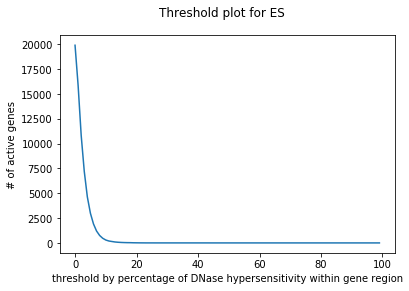

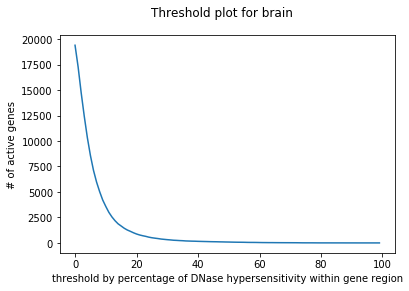

In [91]:
threshold_plot(gene_bounds, "ES")
threshold_plot(gene_bounds, "brain")

### Q: How many genes should be on in a typical mouse cell?

This paper says at least 7000 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2781110/

In [215]:
def threshold(celltype):
    """
    Returns: integer representing threshold such that the number of active genes is around 5000
    """
    xindex = np.arange(100)
    for i in xindex:
        if gene_counts(gene_bounds, celltype, i) < 5000: 
            return i
    return 0

Threshold should be 4 for ES, 8 for MN

In [216]:
threshold("ES")

4

In [233]:
threshold('liver')

8

## Q: How can we confirm that the calculated threshold accurately represents the activity of each cell type?

In [95]:
def gene_on_off(genes, celltype, threshold):
    return genes[celltype].apply(lambda x: 1 if x > threshold else 0)

In [96]:
allowed_chromosomes = [f'chr{x}' for x in (list(range(1,19)) + ['X', 'Y'])]
gene_bounds = gene_bounds.loc[gene_bounds.chrom.isin(allowed_chromosomes)]

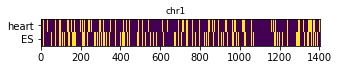

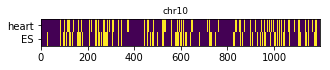

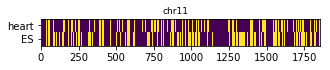

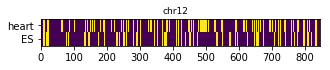

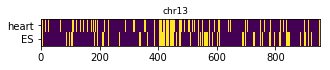

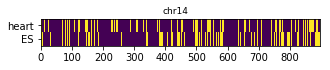

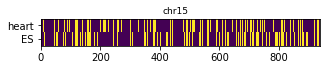

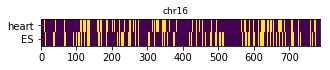

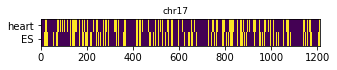

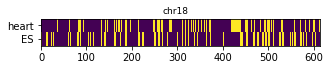

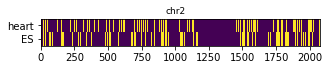

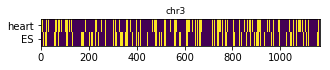

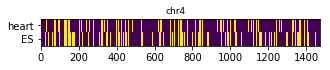

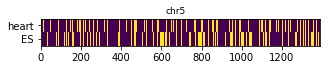

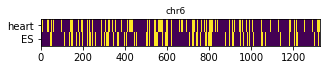

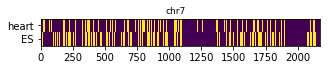

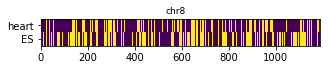

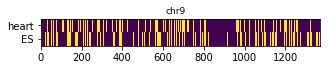

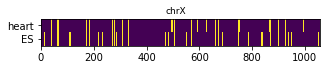

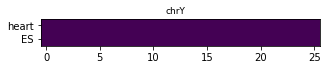

In [27]:
for chrom, group in gene_bounds.groupby('chrom'):
    MN = group.MN_hyper_cov.apply(lambda x: 1 if x > 7 else 0)
    ES = group.ES_hyper_cov.apply(lambda x: 1 if x > 3 else 0)
    img = np.array([MN, ES])
    f = plt.figure()
    f.suptitle(chrom, fontsize=9, y=1.2)
    f.set_size_inches(5,0.5)
    im = plt.imshow(img, aspect="auto")
    plt.yticks(np.arange(2), ['MN','ES'])

### Q: After standardizing the eccdna counts for ES and MN separately, how do we evaluate significant difference between the two standardized values? 

Standardized eccdna counts are stored as a new gene_bounds csv file called gene_bounds_scaled_eccdna.csv. We choose z-scores that are at the far ends of both: for now, we will choose ES scores > 2 and MN scores < -1.

We would like to demonstrate that when ES eccdna counts are high and MN eccdna counts are low, we see a similar reflection in the hypersensitivity data. 

We will first pick out all genes where regional eccdna levels are high for ES and low for MN. 

In [17]:
ES_ecc = gene_bounds[['ES_ecc_cov']]
scaler = StandardScaler()
ES_ecc_std = scaler.fit_transform(ES_ecc)
gene_bounds.ES_ecc_cov = ES_ecc_std

In [18]:
MN_ecc = gene_bounds[['MN_ecc_cov']]
scaler = StandardScaler()
MN_ecc_std = scaler.fit_transform(MN_ecc)
gene_bounds.MN_ecc_cov = MN_ecc_std

In [19]:
gene_bounds.to_csv("new_gene_bounds_scaled_eccdna.csv", sep='\t')

In [29]:
high_ES_low_MN = gene_bounds.loc[(gene_bounds.ES_ecc_cov > 10)&(gene_bounds.MN_ecc_cov < -.5)]
high_ES_low_MN

,name2,start,end,chrom,strand,MN_hyper_cov,ES_hyper_cov,ES_ecc_cov,MN_ecc_cov,start_region,end_region
228,1700029B22Rik,131150578,131150578,chr7,+,0.000000,0.000000,12.985941,-0.507927,131140578,131160578
363,1700095A21Rik,146546873,146546873,chr4,-,0.000000,0.000000,13.470234,-0.507927,146536873,146556873
561,2410141K09Rik,66418244,66441022,chr13,-,0.000000,0.757399,14.808258,-0.507927,66408244,66451022
1347,6030468B19Rik,117797766,117807096,chr11,+,6.212070,4.449369,11.680670,-0.507927,117787766,117817096
1503,9830107B12Rik,48128438,48146008,chr17,-,0.361991,1.290924,19.546060,-0.507927,48118438,48156008
1581,A530064D06Rik,48152836,48166988,chr17,-,0.000000,0.000000,23.999920,-0.507927,48142836,48176988
2832,Arrdc5,56294145,56300243,chr17,-,26.450303,8.525558,11.322819,-0.507927,56284145,56310243
3106,B020004J07Rik,101835370,101838112,chr4,-,0.000000,0.000000,10.769903,-0.507927,101825370,101848112
3228,BC048671,90302796,90305276,chr6,+,0.000000,0.920819,11.591602,-0.507927,90292796,90315276
4719,Chst13,90308967,90325162,chr6,-,4.409449,1.530598,14.718539,-0.507927,90298967,90335162


### Q: Should we standardize the hypersensitivity as well to get a better idea of how much each value differs from the mean?

In [30]:
ES_hyper = gene_bounds[['ES_hyper_cov']]
scaler = StandardScaler()
ES_hyper_std = scaler.fit_transform(ES_hyper)
gene_bounds.ES_hyper_cov = ES_hyper_std

MN_hyper = gene_bounds[['MN_hyper_cov']]
scaler = StandardScaler()
MN_hyper_std = scaler.fit_transform(MN_hyper)
gene_bounds.MN_hyper_cov = MN_hyper_std

gene_bounds.to_csv("gene_bounds_all_scaled.csv", sep='\t')

In [38]:
gene_bounds = pd.read_csv('new_gene_bounds_percent.csv', sep='\t')

In [41]:
high_ES_low_MN = gene_bounds.loc[(gene_bounds.ES_hyper_cov > 10)&(gene_bounds.MN_hyper_cov < 6)]
high_ES_low_MN

,Unnamed: 0,name2,start,end,chrom,strand,MN_hyper_cov,ES_hyper_cov,ES_ecc_cov,MN_ecc_cov,start_region,end_region
501,501,2310002D06Rik,80517954,80517954,chr12,+,1.230000,17.105000,0.000000,14.875000,80507954,80527954
1632,1632,A930001A20Rik,15002727,15002727,chr3,+,0.000000,12.495000,0.000000,0.000000,14992727,15012727
2616,2616,Apoe,19696379,19698230,chr7,-,1.368358,10.438882,2.503318,0.000000,19686379,19708230
3152,3152,B3gnt7,86303543,86306227,chr1,+,0.000000,13.264856,0.000000,0.000000,86293543,86316227
5317,5317,Csf2ra,61225003,61227365,chr19,-,0.000000,19.220106,0.000000,0.000000,61215003,61237365
7520,7520,Fgf4,144861504,144862941,chr7,+,0.000000,11.983953,1.525400,0.000000,144851504,144872941
8006,8006,Gdf3,122606305,122609966,chr6,-,3.376865,14.318921,5.232239,5.075863,122596305,122619966
8690,8690,Gm16833,9260885,9260885,chr9,+,0.000000,12.905000,0.000000,0.000000,9250885,9270885
8926,8926,Gm28626,86304060,86304060,chr1,-,0.000000,15.045000,0.000000,0.000000,86294060,86314060
9268,9268,Gm5144,11907390,11907390,chr15,+,0.000000,18.985000,0.000000,0.000000,11897390,11917390


There is only one gene where we see slightly more hypersensitivity in ES cells after standardization, and more ES eccdna coverage (also relative to the standardization)

### Q: What if we flip it: low eccdna in ES, high in MN?

In [124]:
high_MN_low_ES = gene_bounds.loc[(gene_bounds.ES_ecc_cov < -0.38242)&(gene_bounds.MN_ecc_cov > 5)]
high_MN_low_ES

,name2,start,end,chrom,strand,MN_hyper_cov,ES_hyper_cov,ES_ecc_cov,MN_ecc_cov,start_region,end_region
342,1700081H04Rik,119114543,119114543,chr5,+,-0.609653,-0.738899,-0.382429,6.011161,119104543,119124543
1269,4933438K21Rik,147068436,147068436,chr4,-,-0.852063,-0.947080,-0.382429,5.434413,147058436,147078436
5240,Crebzf,90443014,90448043,chr7,+,1.972356,-0.017171,-0.382429,6.784613,90433014,90458043
6560,Edn1,42301894,42306879,chr13,+,-0.718500,0.326090,-0.382429,6.439548,42291894,42316879
7780,Fuom,140099534,140102441,chr7,-,-0.283090,-0.336358,-0.382429,6.690835,140089534,140112441
8295,Gm11166,13098472,13098472,chr17,-,-0.519930,-0.524472,-0.382429,7.529414,13088472,13108472
8455,Gm13212,145617145,145624394,chr4,+,-0.852063,-0.947080,-0.382429,6.116710,145607145,145634394
8580,Gm15319,20338954,20363032,chr8,-,-0.852063,-0.947080,-0.382429,7.043582,20328954,20373032
8771,Gm1979,26000171,26004727,chr5,-,-0.852063,0.199123,-0.382429,20.050159,25990171,26014727
8787,Gm2016,87876584,87877019,chr12,+,-0.852063,-0.947080,-0.382429,6.573170,87866584,87887019


In [ ]:
hyper_df = pd.read_csv("chrom_hypersensitivity_1-3.csv", sep='\t')
hyper_threshold = hyper_df.loc[(hyper_df.MN_hyper_cov > 60)&(hyper_df.ES_hyper_cov < 5)]
hyper_threshold

In [ ]:
opp_hyper_threshold = hyper_df.loc[(hyper_df.MN_hyper_cov < 10)&(hyper_df.ES_hyper_cov > 30)]
opp_hyper_threshold

In [ ]:
MN_topgenes = hyper_df.sort_values(["MN_hyper_cov"], ascending =False)
MN_topgenes = MN_topgenes.head(100)
ES_topgenes = hyper_df.sort_values(["ES_hyper_cov"], ascending=False)
ES_topgenes = ES_topgenes.head(100)

MN_topgenes.reset_index(inplace=True)
ES_topgenes.reset_index(inplace=True)

len(ES_topgenes.merge(MN_topgenes, indicator=True, how='inner', on='name2'))
# 34 out of the 100 top genes are the same for both cell types, with dataset of 3 chromosomes

## Create zoomed plots of eccdna/hypersensitivity at particular genes

In [36]:
def get_bins(data, chromnum, start, end):
    """
    Now as percentages
    
    chromnum is a string
    data is a bed file (string)
    start is the start of the gene region
    end is the end of the gene region 
    """
    fpath = os.path.join(HYPER_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                          "pval", "qval"], delimiter = "\t")
    loci = loci.loc[(loci.start>start)&(loci.start<end)&(loci.chrom==chromnum)]
    max_pos = loci.end.max()
    if np.isnan(max_pos):
        bins = pd.Series(index = np.arange(0, 1000, 1000))
        return bins.fillna(0)
    
    binsize = 1000

    bins =pd.Series(index = np.arange(0,max_pos, binsize))
    bins = bins.fillna(0)

    for i,l in loci.iterrows():
        first_bin = l.start//binsize
        last_bin =l.end//binsize
        for b in range(first_bin,last_bin+1):
            start_in_bin = max(b*binsize,l.start)
            end_in_bin = min((b+1)*binsize-1 , l.end)
            bins.loc[b*binsize] += (end_in_bin - start_in_bin)/1e1
    return bins

In [35]:
def binned_count(data, chromnum, start, end):
    """
    Returns: dataframe of unique eccdnas within a small region of the genome (binned 1000)
    
    needs to be able to handle --> scenario where there are no unique eccdnas --> not implemented yet
    
    Precondition: 
    chromnum is a string representing a chromosome of form 'chr2'
    start and end are integers
    data is a bed file 
    """
    fpath = os.path.join(NOREPEATS_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    loci = loci.loc[(loci.start>start)&(loci.start<end)&(loci.chrom==chromnum)]

    loci['mid1000'] = (loci[['start','end']].mean(axis = 1))//1e4
    chrom_bin = pd.concat([loci.chrom.rename('x'), 
                           loci.mid1000.rename('y')], axis = 1)

    chrom_bin = chrom_bin.groupby(["x", "y"]).apply(lambda x: x.y.count())
    if chrom_bin.empty:
        return chrom_bin
    chrom_bin = chrom_bin.reset_index(name="count")
    return chrom_bin

In [37]:
def binned_count_shibata(data, chromnum, start, end):
    """
    Returns: dataframe of unique eccdnas within a small region of the genome (binned 1000)
    
    needs to be able to handle --> scenario where there are no unique eccdnas --> not implemented yet
    
    Precondition: 
    chromnum is a string representing a chromosome of form 'chr2'
    start and end are integers
    data is a bed file 
    """
    fpath = os.path.join(SHIBATA_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "readcount", "random"], delimiter = "\t")  
    loci = loci.loc[(loci.start>start)&(loci.start<end)&(loci.chrom==chromnum)]

    loci['mid1000'] = (loci[['start','end']].mean(axis = 1))//1e4
    chrom_bin = pd.concat([loci.chrom.rename('x'), 
                           loci.mid1000.rename('y')], axis = 1)

    chrom_bin = chrom_bin.groupby(["x", "y"]).apply(lambda x: x.y.count())
    if chrom_bin.empty:
        return chrom_bin
    chrom_bin = chrom_bin.reset_index(name="count")
    return chrom_bin

In [196]:
def gene_plot(chrom, start, end):
    """
    Creates gene plot of DNase hypersensitivity and eccdna near a particular gene
    
    Small issues:
    Need to double check that you're using the correct bed files every time
    """
    start = start-10000
    end = end+10000
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    MN_bins = get_bins("heart_ENCFF810UXC.bed", chrom, start, end)
    ES_bins = get_bins("ES_ENCFF319IPQ.bed", chrom, start, end)
    
    MN_eccdna_count = binned_count_shibata('converted_mm10_heart.bed', chrom, start, end)
    ES_eccdna_count = binned_count("ES-1_norepeats.bed", chrom, start, end)

    ax1.plot(MN_bins.loc[start:], color ='g') 
    ax1.plot(ES_bins.loc[start:], color = 'r')
    
    if not (MN_eccdna_count.empty):
        ax2.plot(MN_eccdna_count.y*10000, MN_eccdna_count['count'], "*", color = 'g', label ='heart')
    if not (ES_eccdna_count.empty):
        ax2.plot(ES_eccdna_count.y*10000, ES_eccdna_count['count'], "*", color = 'r', label ='ES')

    gene_region = gene_bounds.loc[(gene_bounds.start>start)&(gene_bounds.end<end)&
                                 (gene_bounds.chrom == chrom)]
    for i in range(len(gene_region)):
        plt.plot(gene_region[["start","end"]].values[i],[10,10],label=gene_region.iloc[i].name)

    ax1.set_ylabel('DNase hypersensitvity (percentage)')
    ax2.set_ylabel('number of unique eccdnas')
    
    ax1.set_xlabel('base pair location in chromosome')
    fig.suptitle('Close up of DNase hypersensitivity and unique eccdna count at specific location in '+chrom)
    plt.legend()

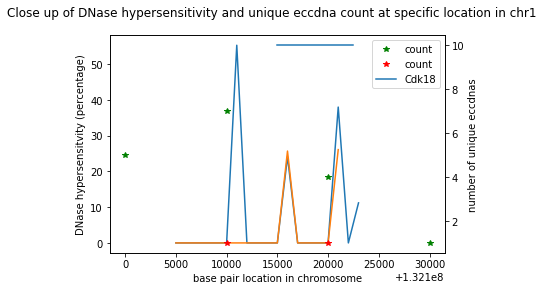

In [111]:
gene_plot('chr1', 132104935, 132132435)

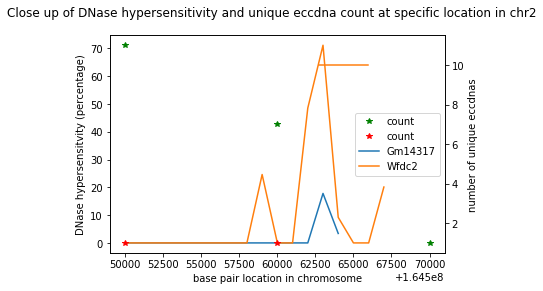

In [103]:
gene_plot('chr2', 164549730, 164569730)

In [ ]:
for gene in hyper_threshold.itertuples():
    gene_plot(gene.chrom, gene.start_region, gene.end_region)

In [48]:
gene_bounds = pd.read_csv('gene_bounds_scaled_eccdna.csv', sep ='\t')

In [55]:
gene_bounds.loc[(gene_bounds.MN_hyper_cov < 5)&(gene_bounds.ES_hyper_cov > 8)&
               (gene_bounds.ES_ecc_cov > 1)&(gene_bounds.MN_ecc_cov < 0)]

,Unnamed: 0,name2,start,end,chrom,strand,MN_hyper_cov,ES_hyper_cov,ES_ecc_cov,MN_ecc_cov,start_region,end_region
8235,8523,Gm14317,164559730,164559730,chr2,+,1.065000,8.685000,1.120045,-0.186076,164549730,164569730
9703,10025,H2-M5,36986977,36989504,chr17,-,1.362809,9.339903,1.457231,-0.101941,36976977,36999504
9772,10095,Halr1,52113684,52113684,chr6,+,0.000000,9.260000,1.403765,-0.251571,52103684,52123684
12151,12554,Mc5r,68337624,68339690,chr18,+,2.642074,8.370344,1.835454,-0.030058,68327624,68349690


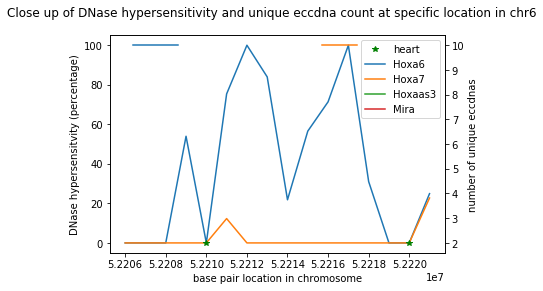

In [70]:
gene_plot("chr6", 52205288, 52225288)

In [188]:
gene_bounds.heart_hyper_cov.corr(gene_bounds.heart_ecc_cov)

0.05781303708960415

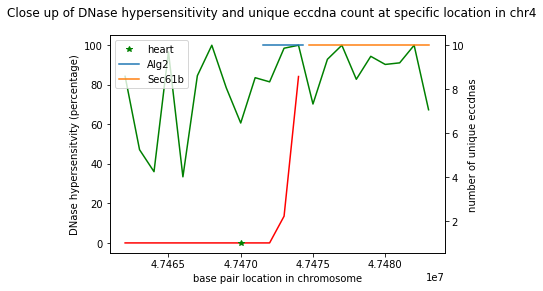

In [202]:
gene_plot('chr4', 47461558, 47484286)

In [175]:
gene_bounds.loc[(gene_bounds.ES_hyper_cov < 5)&(gene_bounds.heart_hyper_cov > 90)]

,start,end,chrom,strand,MN_hyper_cov,MN_ecc_cov,ES_hyper_cov,ES_ecc_cov,heart_hyper_cov,heart_ecc_cov,brain_hyper_cov,brain_ecc_cov,start_region,end_region
name2,,,,,,,,,,,,,,
4930515B02Rik,140878057,140878057,chr4,+,2.850000,93.250000,1.140000,0.000000,72.965000,1.090000,1.565000,0.000000,140868057,140888057
Alg2,47471558,47474286,chr4,-,8.179338,79.421859,4.298662,0.000000,78.040303,1.372756,6.991376,0.915171,47461558,47484286
Ankrd46,36479256,36486105,chr15,-,2.722634,83.165109,0.297963,15.885135,84.051548,0.000000,0.353831,2.007524,36469256,36496105
Ccin,43983594,43985361,chr4,+,9.087150,61.515138,1.878991,5.191345,73.606836,0.000000,30.233840,0.725869,43973594,43995361
Cxcr2,74158348,74159428,chr1,+,0.000000,67.296015,0.000000,0.000000,71.238140,0.000000,0.000000,0.000000,74148348,74169428
Gm32496,8632454,8632454,chr3,+,1.095000,79.285000,0.000000,0.000000,72.345000,0.000000,0.305000,0.000000,8622454,8642454
Gp9,87779004,87779538,chr6,+,9.774033,78.104607,0.000000,0.000000,76.078699,0.000000,0.000000,1.650920,87769004,87789538
Hoxa11,52243359,52245719,chr6,-,0.997317,77.616279,0.889982,0.000000,89.302326,0.000000,2.070662,0.000000,52233359,52255719
Hoxa11os,52249769,52249769,chr6,+,2.520000,95.315000,1.285000,0.000000,83.695000,0.000000,8.890000,0.000000,52239769,52259769


In [56]:
gene_bounds.loc[(gene_bounds.heart_hyper_cov < 3)&(gene_bounds.ES_hyper_cov > 8)&
               (gene_bounds.ES_ecc_cov > 10)&(gene_bounds.heart_ecc_cov < 5)]

,start,end,chrom,strand,ES_hyper_cov,ES_ecc_cov,start_region,end_region,heart_hyper_cov,heart_ecc_cov
name2,,,,,,,,,,
H2-M5,36986977,36989504,chr17,-,9.339903,12.611533,36976977,36999504,2.188485,0.0
Halr1,52113684,52113684,chr6,+,9.260000,12.245000,52103684,52123684,0.000000,0.0


In [160]:
gene_bounds.loc[(gene_bounds.brain_hyper_cov < 3)&(gene_bounds.ES_hyper_cov > 8)&
               (gene_bounds.ES_ecc_cov > 10)&(gene_bounds.brain_ecc_cov < 5)]

,start,end,chrom,strand,MN_hyper_cov,MN_ecc_cov,ES_hyper_cov,ES_ecc_cov,heart_hyper_cov,heart_ecc_cov,brain_hyper_cov,brain_ecc_cov,start_region,end_region
name2,,,,,,,,,,,,,,
H2-M5,36986977,36989504,chr17,-,1.362809,70.87495,9.339903,12.611533,2.188485,0.0,2.703423,0.0,36976977,36999504
Halr1,52113684,52113684,chr6,+,0.000000,66.34000,9.260000,12.245000,0.000000,0.0,0.000000,0.0,52103684,52123684


In [170]:
gene_bounds.loc[(gene_bounds.ES_hyper_cov < 3)&(gene_bounds.brain_hyper_cov > 80)]

,start,end,chrom,strand,MN_hyper_cov,MN_ecc_cov,ES_hyper_cov,ES_ecc_cov,heart_hyper_cov,heart_ecc_cov,brain_hyper_cov,brain_ecc_cov,start_region,end_region
name2,,,,,,,,,,,,,,
Dmrta2,109979862,109982653,chr4,+,8.275196,114.852354,1.597122,0.0,25.251196,1.645386,83.625115,0.947743,109969862,109992653


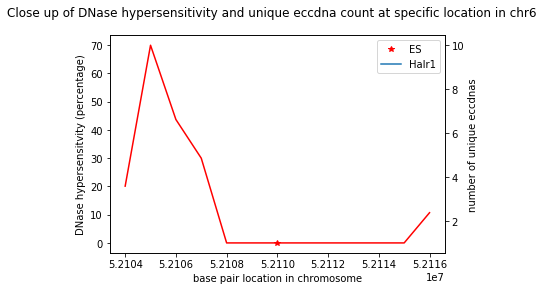

In [109]:
gene_plot('chr6', 52103684, 52123684)

In [154]:
gene_bounds.loc[(gene_bounds.heart_hyper_cov < 3)&(gene_bounds.brain_hyper_cov > 7)&
               (gene_bounds.brain_ecc_cov > 7)&(gene_bounds.heart_ecc_cov < 5)]

,start,end,chrom,strand,MN_hyper_cov,MN_ecc_cov,ES_hyper_cov,ES_ecc_cov,heart_hyper_cov,heart_ecc_cov,brain_hyper_cov,brain_ecc_cov,start_region,end_region
name2,,,,,,,,,,,,,,
Dio3,110279231,110280146,chr12,+,0.621563,91.245518,6.69376,0.0,0.00,2.295004,18.369591,9.524265,110269231,110290146
Dio3os,110278068,110278068,chr12,-,0.650000,90.625000,7.00000,0.0,0.00,2.400000,19.210000,9.960000,110268068,110288068
Mir1247,110278129,110278129,chr12,-,0.650000,90.015000,7.00000,0.0,0.00,2.400000,19.210000,9.960000,110268129,110288129
Mir8107,110636115,110636115,chr9,-,3.475000,83.820000,2.26000,0.0,1.51,1.815000,7.435000,7.630000,110626115,110646115


In [151]:
gene_bounds.loc[(gene_bounds.brain_hyper_cov < 3)&(gene_bounds.heart_hyper_cov > 7)&
               (gene_bounds.heart_ecc_cov > 7)&(gene_bounds.brain_ecc_cov < 5)]

,start,end,chrom,strand,MN_hyper_cov,MN_ecc_cov,ES_hyper_cov,ES_ecc_cov,heart_hyper_cov,heart_ecc_cov,brain_hyper_cov,brain_ecc_cov,start_region,end_region
name2,,,,,,,,,,,,,,
Cckar,53699755,53707357,chr5,-,0.728208,79.356568,1.550612,0.0,13.57148,7.437867,2.941816,0.0,53689755,53717357


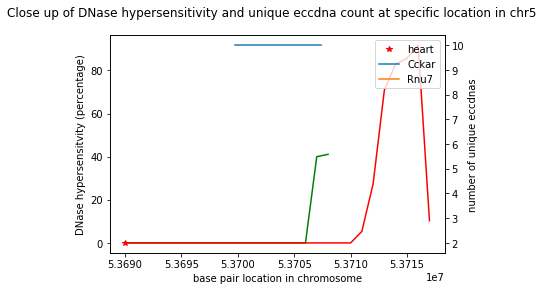

In [128]:
gene_plot('chr5',53689755, 53717357)

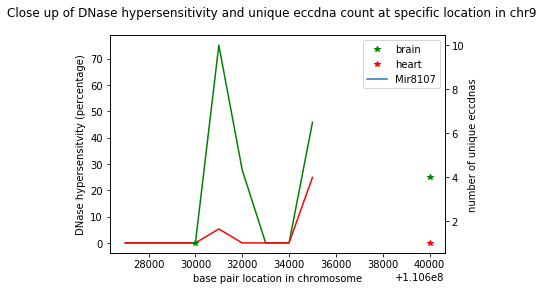

In [125]:
gene_plot('chr9', 110626115,110646115)